## Hadith Navigator

A semantic search system for exploring an extensive Hadith database, leveraging NLP techniques to retrieve contextually relevant texts based on user queries.

- By: Abdulmunim Jundurahman
  Icog Labs Training Program,
  2024


In [1]:
# let us load the DB and doe some EDA

import pandas as pd

df = pd.read_csv('data/all_hadiths.csv')

### Step 1. EDA


In [2]:
df.head()

,id,hadith_id,source,chapter_no,hadith_no,chapter,chain_indx,text_ar,text_en
0,0,1,Sahih Bukhari,1,1,Revelation - كتاب بدء الوحى,"30418, 20005, 11062, 11213, 11042, 3",حدثنا الحميدي عبد الله بن الزبير، قال حدثنا سف...,Narrated 'Umar bin Al-Khattab: ...
1,1,2,Sahih Bukhari,1,2,Revelation - كتاب بدء الوحى,"30355, 20001, 11065, 10511, 53",حدثنا عبد الله بن يوسف، قال أخبرنا مالك، عن هش...,Narrated 'Aisha: ...
2,2,3,Sahih Bukhari,1,3,Revelation - كتاب بدء الوحى,"30399, 20023, 11207, 11013, 10511, 53",حدثنا يحيى بن بكير، قال حدثنا الليث، عن عقيل، ...,Narrated 'Aisha: (the m...
3,3,4,Sahih Bukhari,1,4,Revelation - كتاب بدء الوحى,"11013, 10567, 34",قال ابن شهاب وأخبرني أبو سلمة بن عبد الرحمن، أ...,Narrated Jabir bin 'Abdullah Al-Ansari while ...
4,4,5,Sahih Bukhari,1,5,Revelation - كتاب بدء الوحى,"20040, 20469, 11399, 11050, 17",حدثنا موسى بن إسماعيل، قال حدثنا أبو عوانة، قا...,Narrated Said bin Jubair: ...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34441 entries, 0 to 34440
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          34441 non-null  int64 
 1   hadith_id   34441 non-null  int64 
 2   source      34441 non-null  object
 3   chapter_no  34441 non-null  int64 
 4   hadith_no   34441 non-null  object
 5   chapter     34441 non-null  object
 6   chain_indx  34318 non-null  object
 7   text_ar     34433 non-null  object
 8   text_en     33588 non-null  object
dtypes: int64(3), object(6)
memory usage: 2.4+ MB


In [4]:
df.describe() # let us check it statistically

,id,hadith_id,chapter_no
count,34441.000000,34441.000000,34441.000000
mean,174.949188,24558.251677,29.603467
std,607.052596,16983.092973,23.002504
min,0.000000,1.000000,0.000000
25%,28.000000,10959.000000,10.000000
50%,74.000000,22262.000000,25.000000
75%,158.000000,41391.000000,45.000000
max,7695.000000,54227.000000,98.000000


In [5]:
df.isnull().sum() # let us check for missing values

id              0
hadith_id       0
source          0
chapter_no      0
hadith_no       0
chapter         0
chain_indx    123
text_ar         8
text_en       853
dtype: int64

In [6]:
# drop the missing values
df = df.dropna(subset=['text_en'])

In [7]:
print("Unique Hadith IDs:", df['hadith_id'].nunique())
print("Unique Chain Indexes:", df['chain_indx'].nunique())

Unique Hadith IDs: 32849
Unique Chain Indexes: 27809


In [8]:
# Let us see average text length 
df["text_length"] = df["text_en"].apply(lambda x: len(str(x).split()))
print("Average Text Length (EN): ", df["text_length"].mean())

Average Text Length (EN):  76.27104918423247


### Step 2 - Preprocessing


In [9]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re

In [22]:
def preprocess_text(text):
    # Normalization
    text = text.lower()  # convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation and non-alphabetic characters
    text = re.sub(r'\b\w{1,2}\b', '', text)  # remove words less than 3 characters

    # Tokenize text
    tokens = word_tokenize(text)
    
        # Stop words setup
    base_stop_words = set(stopwords.words('english'))
    # Manually added some stopwords that are common in Ahadith
    islamic_stopwords = [
        'Prophet', 'Muhammad', 'PBUH', 'Messenger', 'Allah', 'Apostle', 'Narrated', 'Reported',
        'Heard', 'Told', 'Peace', 'Be', 'Upon', 'Him', 'Verily', 'Indeed', 'Allahs', 'Say', 'Thy', 
        'Thee', 'Thou', 'Man', 'One', 'Came', 'Went', 'Day', 'Said', 'Asked', 'Saw'
    ]
    # Convert islamic_stopwords to lowercase before adding to the base set
    islamic_stopwords = set(word.lower() for word in islamic_stopwords)
    stop_words = base_stop_words.union(islamic_stopwords)
    
    
    # Remove stopwords
    tokens = [token for token in tokens if token not in stop_words]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # Reconstruct the cleaned text
    cleaned_text = ' '.join(lemmatized_tokens)
    return cleaned_text

In [23]:
example_text = "Umar bin Alkhattab said, Allah’s reward is vast."
print(preprocess_text(example_text))

umar bin alkhattab reward vast


In [18]:
df['cleaned_text'] = df['text_en'].apply(preprocess_text)

In [19]:
df['cleaned_text'].head()

0    umar bin alkhattab saying reward deed depends ...
1    aisha mother faithful believer alharith bin hi...
2    aisha mother faithful believer commencement di...
3    jabir bin abdullah alansari talking period pau...
4    bin jubair ibn abbas explanation statement mov...
Name: cleaned_text, dtype: object

In [13]:
# Let us see the most common words

import matplotlib.pyplot as plt
from wordcloud import WordCloud

def generate_word_cloud(dataframe, column_name, save_path=None):
    long_string = ' '.join(list(dataframe[column_name]))
    wordcloud = WordCloud(background_color="black", max_words=5000, contour_width=3, contour_color='steelblue')
    wordcloud.generate(long_string)
    # Visualization
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    if save_path:
        plt.savefig(save_path)  # Save the figure to a file
    plt.show()

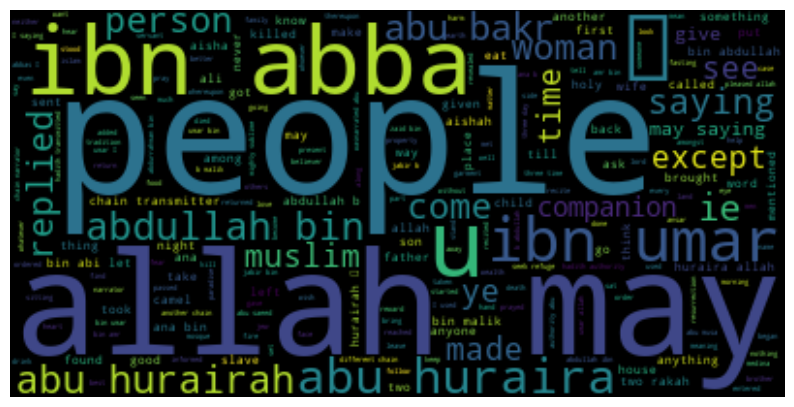

In [14]:
generate_word_cloud(df, 'cleaned_text', save_path='hadith_word_cloud.png')